<>:37: SyntaxWarning: invalid escape sequence '\w'
<>:37: SyntaxWarning: invalid escape sequence '\w'
C:\Users\MHC V(D)J\AppData\Local\Temp\ipykernel_10164\3538440927.py:37: SyntaxWarning: invalid escape sequence '\w'
  lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))


📊 Training dataset - sample count per class:
Variant_Id
Gamma      5597
Alpha      5511
Delta      5495
Omicron    5162
Beta       4271
Name: count, dtype: int64

🧮 Total sequences in training dataset: 26036

📊 Validation dataset - sample count per class:
Variant_Id
Beta       1403
Alpha       625
Delta       494
Gamma       437
Omicron     103
Name: count, dtype: int64

🧮 Total sequences in validation dataset: 3062

📝 Variant counts saved to: variant_distribution\variant_counts.txt


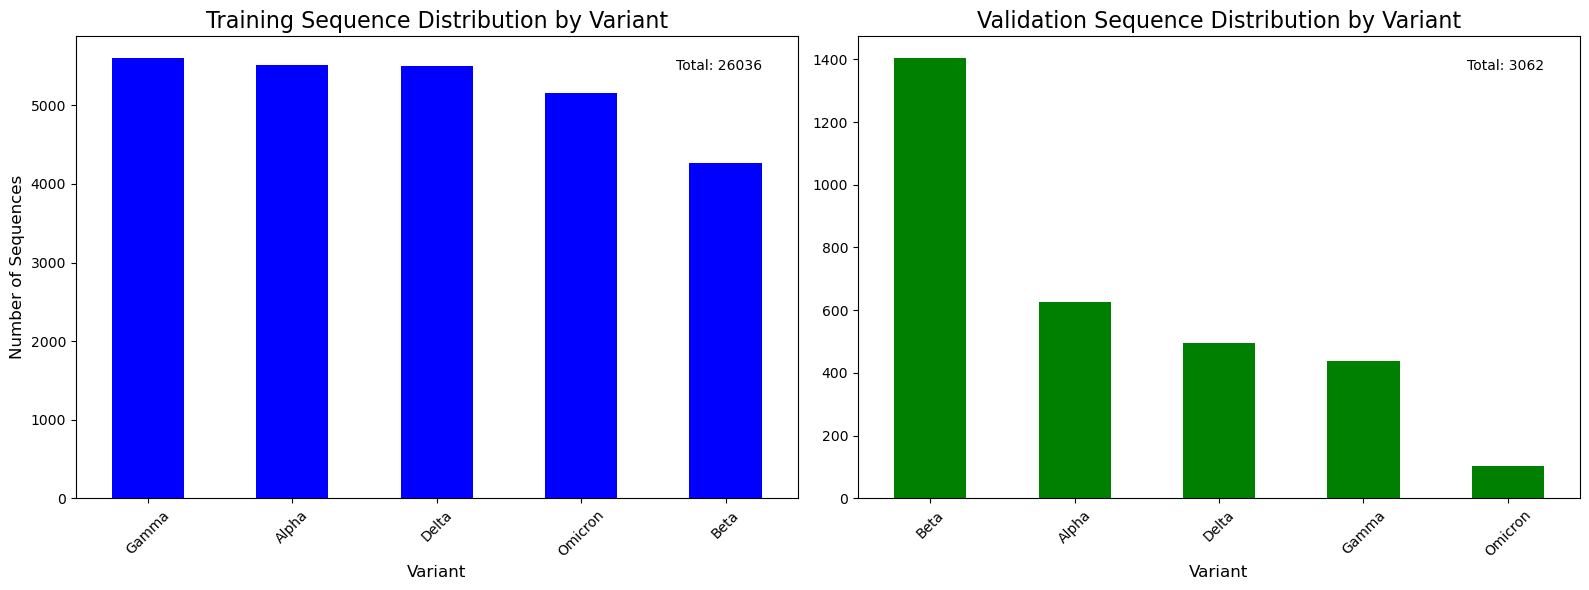

✅ Combined plot with independent y-axis saved to: variant_distribution\variant_distribution_combined_independent_y.png

🚀 Training with Gamma left out...

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.2491 - loss: 1.4695 - val_accuracy: 0.2696 - val_loss: 1.4056
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.2768 - loss: 1.3853 - val_accuracy: 0.2723 - val_loss: 1.3980
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.2701 - loss: 1.3852 - val_accuracy: 0.2527 - val_loss: 1.4153
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - accuracy: 0.2579 - loss: 1.3879 - val_accuracy: 0.2696 - val_loss: 1.4003
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.2674 - loss: 1.3868 - val_accuracy: 0.2522 - val_loss: 1.3954
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.2710 - loss: 1.3858 - val_accuracy: 0.2740 - val_loss: 1.3857
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - accuracy: 0.2771 - loss: 1.3825 -

In [ ]:
# === LOVO Full Loop: Training, Evaluation (Test + Validation) ===
import keras
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, f1_score
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense
import time

# === Set random seed ===
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

dataset_2 = '../data/sequences.aln.fas' # huge dataset with 26k sequences
dataset_3 = '../data/validation.sequences.fas'


#inputfile = [dataset_2,dataset_3]

def preprocess(inputfile):
    lines = []
    header = []
    with open (inputfile, 'r') as fasta_file:
    
        for line in fasta_file:
            if line.startswith(">"):
            #extract fasta headers
                lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))
            
            next
            #extract sequence lines
            if not line.startswith(">"):
                header.append(line.replace("\n",''))

            
    #Create dictionary of header and sequences and create a dataframe
    data = {lines[i]:header[i] for i in range(len(header))}
    data = pd.DataFrame(list(data.items()),columns = ['Seq_ID','sequence']) 

    data["sequence"] = data["sequence"].str.upper() #ensure the sequence is un uppercase. Important for encoding
    data["Variant_Id"] = data["Seq_ID"].apply(lambda i: i.split('/')[0]) #extracting variant names from sequnce file
    data = data.drop("Seq_ID", axis=1)
    
    return data



dataset_2 = preprocess(dataset_2)
dataset_3 = preprocess(dataset_3)
# Create output directory
output_dir = "variant_distribution"
os.makedirs(output_dir, exist_ok=True)

# Capitalize variant names
dataset_2["Variant_Id"] = dataset_2["Variant_Id"].astype(str).str.capitalize()
dataset_3["Variant_Id"] = dataset_3["Variant_Id"].astype(str).str.capitalize()

# Count variant IDs
class_counts_2 = dataset_2["Variant_Id"].value_counts()
total_count_2 = class_counts_2.sum()

class_counts_3 = dataset_3["Variant_Id"].value_counts()
total_count_3 = class_counts_3.sum()

# Print counts
print("📊 Training dataset - sample count per class:")
print(class_counts_2)
print(f"\n🧮 Total sequences in training dataset: {total_count_2}\n")

print("📊 Validation dataset - sample count per class:")
print(class_counts_3)
print(f"\n🧮 Total sequences in validation dataset: {total_count_3}\n")

# Save counts to a text file
counts_path = os.path.join(output_dir, "variant_counts.txt")
with open(counts_path, 'w') as f:
    f.write("Training Dataset (dataset_2):\n")
    f.write(class_counts_2.to_string())
    f.write(f"\n\nTotal: {total_count_2}\n\n")
    
    f.write("Validation Dataset (dataset_3):\n")
    f.write(class_counts_3.to_string())
    f.write(f"\n\nTotal: {total_count_3}\n")

print(f"📝 Variant counts saved to: {counts_path}")

# Plot both in subplots with independent y-scales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Independent y-scale

# Training plot
class_counts_2.plot(kind="bar", color="blue", ax=axes[0])
axes[0].set_title("Training Sequence Distribution by Variant", fontsize=16)
axes[0].set_xlabel("Variant", fontsize=12)
axes[0].set_ylabel("Number of Sequences", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].text(0.95, 0.95, f"Total: {total_count_2}", transform=axes[0].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Validation plot
class_counts_3.plot(kind="bar", color="green", ax=axes[1])
axes[1].set_title("Validation Sequence Distribution by Variant", fontsize=16)
axes[1].set_xlabel("Variant", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].text(0.95, 0.95, f"Total: {total_count_3}", transform=axes[1].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.tight_layout()

# Save combined plot
plot_path = os.path.join(output_dir, "variant_distribution_combined_independent_y.png")
plt.savefig(plot_path, dpi=600, bbox_inches='tight', format='png')
plt.show()

print(f"✅ Combined plot with independent y-axis saved to: {plot_path}")

def variant_to_numerical(sequence_data):
    """
    Function to map convetional variant names to numeric
    pass a sequence data with column named "Variant_ID".
    
    """
    
    variant = {"Gamma" : 0, "Delta" : 1, "Beta" : 2, "Alpha" : 3, "Omicron":4}
    
    
    sequence_data["Variant_Id"] = sequence_data["Variant_Id"].map(variant)
    
    return sequence_data
    

variant_to_numerical(dataset_2)

dataset_2.head()


def encode_seq(seq_data):
    """
    Function to convert nucleotides to binary form and hot-encoded

    Arguments :
    seq_data = sequence dataframe with "sequence" and "Variant_ID" columns

    char : total number of unique characters in the whole dataset. This is used to 
    bin : array list of zeros corresponding to the number of characters

    """

    ntds = []
    for i in seq_data['sequence']:
        for seq in i:
            ntd = seq.strip()
            ntds.append(ntd.upper())
        
    char = list(set(ntds))
    
    bin = [0] * len(char)
    bin0  = [0] * len(char)
    bin1  = [0] * len(char)
    bin2  = [0] * len(char)
    bin3  = [0] * len(char)
    
    #Create a dictionary of arrays to the seqeunce characters
    Encode = {}

    for i in char:
        if i == 'A':
            bin0[0] = 1
            Encode[i] = bin0
        elif i == 'C':
            bin1[1] = 1
            Encode[i] = bin1
        elif i == 'G':
            bin2[2] = 1
            Encode[i] = bin2
        elif i == 'T':
            bin3[3] = 1
            Encode[i] = bin3
        else:
            Encode[i] = bin
    
      #convert the sequence characters to encoded form and append to the list

    encoded_list = []

    for seq in seq_data["sequence"]:
        encoded_list.append([Encode[x] for x in seq])

    return encoded_list


# This updated cell loops through each variant as the left-out class (LOVO)
# It performs training, test evaluation, and validation evaluation with all output files saved

variant_names = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]

# Pre-encode datasets
X_mine_data_kmer_2 = np.array(encode_seq(dataset_2))
y_mine_kmer_2 = np.array(dataset_2['Variant_Id'])
X_mine_data_kmer_3 = np.array(encode_seq(dataset_3))
y_mine_kmer_3 = np.array(dataset_3['Variant_Id'])

# === Begin LOVO loop ===
variant_names = ["Gamma", "Delta", "Beta", "Alpha", "Omicron"]
all_class_names = variant_names + ["Unknown"]
confidence_threshold = 0.8
summary_records = []

for leave_out_label in range(5):
    left_out_variant = variant_names[leave_out_label]
    print(f"\n🚀 Training with {left_out_variant} left out...\n")

    # === Mask for LOVO ===
    train_mask = y_mine_kmer_2 != leave_out_label
    test_mask = y_mine_kmer_2 == leave_out_label

    X_train_full = X_mine_data_kmer_2[train_mask]
    y_train_full = y_mine_kmer_2[train_mask]
    X_test_lovo = X_mine_data_kmer_2[test_mask]
    y_test_lovo = y_mine_kmer_2[test_mask]

    # === Split ===
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_full, y_train_full, test_size=0.2,
        stratify=y_train_full, random_state=42)

    y_train = to_categorical(y_train, num_classes=5)
    y_test = to_categorical(y_test, num_classes=5)

    # === Rebuild Model ===
    input_layer = Input(shape=X_mine_data_kmer_2.shape[1:])
    x = Conv1D(filters=54, kernel_size=6, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=5)(x)
    x = Dropout(0.5)(x)
    x = Conv1D(filters=27, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(filters=14, kernel_size=2, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.1)(x)
    x = Conv1D(filters=7, kernel_size=2, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Bidirectional(LSTM(512))(x)
    x = Dropout(0.01)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128)(x)
    x = Dense(64)(x)
    x = Dense(32)(x)
    x = Dense(16)(x)
    output = Dense(5, activation='softmax')(x)

    cnn_bilstm_model = Model(inputs=input_layer, outputs=output)
    cnn_bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # === Train ===
    early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=8, restore_best_weights=True)
    start_time = time.time()
    history = cnn_bilstm_model.fit(
        X_train, y_train,
        batch_size=1000,
        validation_data=(X_test, y_test),
        epochs=30,
        callbacks=[early_stop]
    )
    train_duration = time.time() - start_time
    print(f"✅ Training time for {left_out_variant}: {train_duration:.2f} seconds")

    # === Create Output Dirs ===
    base_dir = f"results/leave_out_{left_out_variant}"
    test_dir = os.path.join(base_dir, "test_evaluation")
    val_dir = os.path.join(base_dir, "validation_evaluation")
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # === Test Evaluation ===
    eval_start = time.time()
    y_pred_probs = cnn_bilstm_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    target_names = [v for i, v in enumerate(variant_names) if i != leave_out_label]
    report = classification_report(y_true_classes, y_pred_classes, target_names=target_names, zero_division=0)
    with open(os.path.join(test_dir, "classification_report.txt"), "w") as f:
        f.write(report)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix - Test - Left out {left_out_variant}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(test_dir, "confusion_matrix.png"), dpi=600)
    plt.close()

    np.savetxt(os.path.join(test_dir, "confusion_matrix_raw.txt"), cm, fmt="%d")
    acc = accuracy_score(y_true_classes, y_pred_classes)
    y_pred_probs_trimmed = y_pred_probs[:, :4]
    loss = log_loss(y_true_classes, y_pred_probs_trimmed, labels=[0, 1, 2, 3])

    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(test_dir, "accuracy_curve.png"), dpi=600)
    plt.close()

    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(test_dir, "loss_curve.png"), dpi=600)
    plt.close()

    eval_end = time.time()
    with open(os.path.join(test_dir, "time_log.txt"), "w") as f:
        f.write(f"Total Evaluation Time: {eval_end - eval_start:.2f} seconds\n")

    # === Validation Evaluation ===
    val_start = time.time()
    Y_pred_probs = cnn_bilstm_model.predict(X_mine_data_kmer_3)
    Y_pred_classes = np.argmax(Y_pred_probs, axis=1)
    Y_max_probs = np.max(Y_pred_probs, axis=1)
    Y_pred_classes_flagged = np.where(Y_max_probs >= confidence_threshold, Y_pred_classes, -1)

    report_val = classification_report(
        y_mine_kmer_3,
        Y_pred_classes_flagged,
        labels=[0, 1, 2, 3, 4, -1],
        target_names=all_class_names,
        zero_division=0
    )
    with open(os.path.join(val_dir, "classification_report.txt"), "w") as f:
        f.write(report_val)

    cm_val = confusion_matrix(y_mine_kmer_3, Y_pred_classes_flagged, labels=[0, 1, 2, 3, 4, -1])
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=all_class_names, yticklabels=variant_names + ["Unknown"])
    plt.title(f"Confusion Matrix - Validation - Left out {left_out_variant}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(val_dir, "confusion_matrix.png"), dpi=600)
    plt.close()
    np.savetxt(os.path.join(val_dir, "confusion_matrix_raw.txt"), cm_val, fmt="%d")

    filtered_idxs = Y_pred_classes_flagged != -1
    val_acc = accuracy_score(y_mine_kmer_3[filtered_idxs], Y_pred_classes_flagged[filtered_idxs])
    val_loss = log_loss(y_mine_kmer_3, Y_pred_probs, labels=[0, 1, 2, 3, 4])
    val_f1 = f1_score(y_mine_kmer_3[filtered_idxs], Y_pred_classes_flagged[filtered_idxs], average='weighted')

    with open(os.path.join(val_dir, "metrics_summary.txt"), "w") as f:
        f.write(f"Accuracy (excluding Unknown): {val_acc:.4f}\n")
        f.write(f"Log Loss: {val_loss:.4f}\n")
        f.write(f"F1 Score (weighted, excluding Unknown): {val_f1:.4f}\n")
        f.write(f"Flagged as Unknown: {(Y_pred_classes_flagged == -1).sum()} samples\n")

    val_end = time.time()
    with open(os.path.join(val_dir, "time_log.txt"), "w") as f:
        f.write(f"Total Validation Evaluation Time: {val_end - val_start:.2f} seconds\n")

    print(f"✅ Validation evaluation for {left_out_variant} complete.\n")

# === End LOVO loop ===

# === Save aggregated summary ===
summary_df = pd.DataFrame(summary_records)
summary_df.to_csv("results/lovo_aggregated_summary.csv", index=False)
print("✅ LOVO loop complete. Summary saved to results/lovo_aggregated_summary.csv")
